---
# <div align="center"><font color='green'></font></div>
# <div align="center"><font color='green'>Machine Learning Assignment 2</font></div>
## <div align="center"> <font color='green'>Group Members: Shreyas Shah (s4005805), Duy Nguyen Hoang (s3978268)</font></div>
---

# Project Overview

This project focuses on developing image classification models using histopathology patch images from a colon cancer dataset. The goal is to automatically classify small tissue patches into medically relevant categories, which could help support pathologists in cancer diagnosis workflows.

---

## Target and Task Explanation

There are **two main classification tasks** in this project:

### 1. **Binary Classification Task** – `isCancerous` (Task 1)
- **Target Variable:** `isCancerous`  
- **Type:** Binary classification (`0 = Non-cancerous`, `1 = Cancerous`)
- **Goal:** Train a model that predicts whether a given tissue patch is cancerous or not.
- **Use Case:** Assists in early detection by filtering out non-cancerous tissue and highlighting potential cancer regions.

### 2. **Multi-Class Classification Task** – `cellTypeName` (Task 2)
- **Target Variable:** `cellTypeName`  
- **Type:** Multi-class classification (4 categories: `epithelial`, `inflammatory`, `fibroblast`, `others`)
- **Goal:** Build a model that predicts the type of cell present in the image.
- **Use Case:** Provides further insight into tissue structure and cellular makeup, which can improve pathology assessments and guide further analysis.

---

These tasks are performed using supervised learning, with models trained on labelled images. Both tasks require separate preprocessing and modelling strategies to handle different label types and class distributions.

# Loading Dataset and Data Splitting

### Reproducibility
- A fixed `random_state=42` is used throughout to make sure results are consistent every time the notebook is run.
- `np.random.seed(42)` makes NumPy operations predictable if they're used later.
- `keras.utils.set_random_seed(42)` ensures Keras training steps (like weight initialisation and dropout) are also repeatable.

### Train / Validation / Test Split (Patient-Aware)
- The dataset is split into 70% training, 20% validation, and 10% test using GroupShuffleSplit, based on `patientID`.
- This ensures that no patches from the same patient appear in multiple sets, which avoids data leakage and makes the model's performance more realistic.
- The split still maintains class balance using stratified group sampling logic.
- The training set provides enough data to learn features, the validation set helps with tuning and the test set gives a fair final evaluation using completely unseen patients.

In [15]:
import os
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import GroupShuffleSplit

# Reproducibility
SEED = 42
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)

# ---------------
# 2. Load the Data
# ---------------
DATA_DIR = 'Image_classification_data'
CSV_PATH = os.path.join(DATA_DIR, 'data_labels_mainData.csv')

# Read labels
data = pd.read_csv(CSV_PATH)
print(f"Total samples: {len(data)}")
data.head()

# Build absolute image paths
data['image_path'] = data['ImageName'].apply(
    lambda fname: os.path.join(DATA_DIR, 'patch_images', fname)
)

# ---------------
# 3. Train / Validation / Test Split (Patient-Aware)
# ---------------

# Split off test set (10%) using patient ID groups
splitter = GroupShuffleSplit(test_size=0.10, n_splits=1, random_state=SEED)
train_val_idx, test_idx = next(splitter.split(data, groups=data['patientID']))
train_val_data = data.iloc[train_val_idx]
test_data = data.iloc[test_idx]

# Split train and validation (remaining 90% → 70% train, 20% val)
splitter_val = GroupShuffleSplit(test_size=0.2222, n_splits=1, random_state=SEED)
train_idx, val_idx = next(splitter_val.split(train_val_data, groups=train_val_data['patientID']))
train_data = train_val_data.iloc[train_idx]
val_data = train_val_data.iloc[val_idx]

print(f"Train samples:      {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples:       {len(test_data)}")
print("Validation isCancerous counts:\n", val_data.isCancerous.value_counts())
print("Test     isCancerous counts:\n", test_data.isCancerous.value_counts())

Total samples: 9896
Train samples:      6643
Validation samples: 2375
Test samples:       878
Validation isCancerous counts:
 isCancerous
0    1200
1    1175
Name: count, dtype: int64
Test     isCancerous counts:
 isCancerous
0    493
1    385
Name: count, dtype: int64


# Exploratory Data Analysis (EDA)

### Plot Justifications

**Class Distribution (isCancerous)**
- A bar chart shows how many cancerous vs non-cancerous samples are in the training data.
- This helps check for class imbalance, which can make the model favour the more common class.
- Knowing this early helps decide whether to use class weights or data balancing techniques later.

**Cell-Type Distribution**
- A bar chart shows how often each cell type appears in the training data.
- This matters for Task 2, where the model needs to predict the cell type.
- If some cell types are rare, we might need to use augmentation or rebalancing to help the model learn them properly.

**Patient-Level Patch Counts**
- A histogram shows how many image patches come from each patient.
- Some patients have way more patches than others, which can cause the model to overfit to those patients.
- This could be important later when designing how to validate the model fairly.

**Sample Images per Class (isCancerous)**
- Five example images from each class are shown to visually check the dataset.
- This helps spot any obvious issues like wrong labels, corrupted images or weird patterns.
- It also shows whether the two classes (cancerous vs non-cancerous) look different enough for a model to learn from.

**Sample Images per Cell Type**
- Three sample images are shown for each cell type.
- This gives a quick look at whether the cell types have clear visual differences.
- If some types look very similar, the model might need extra help to tell them apart, like more features or better augmentation.


Class distribution in training set:
isCancerous
0    4124
1    2519
Name: count, dtype: int64


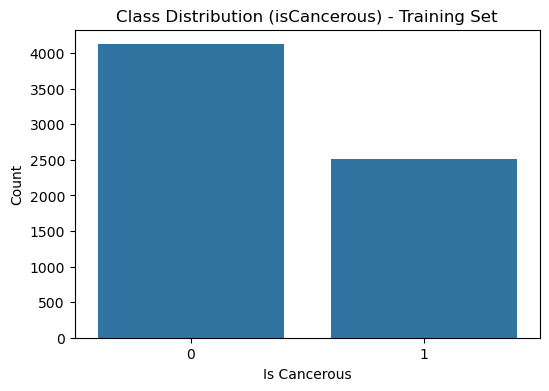


Cell-type distribution in training set:
cellTypeName
epithelial      2519
inflammatory    1924
fibroblast      1192
others          1008
Name: count, dtype: int64


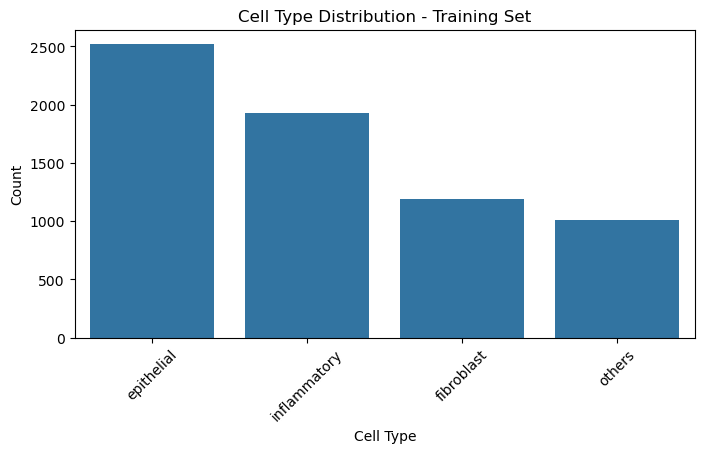

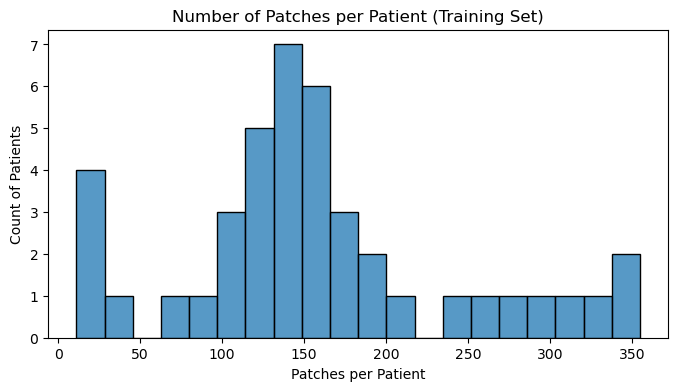

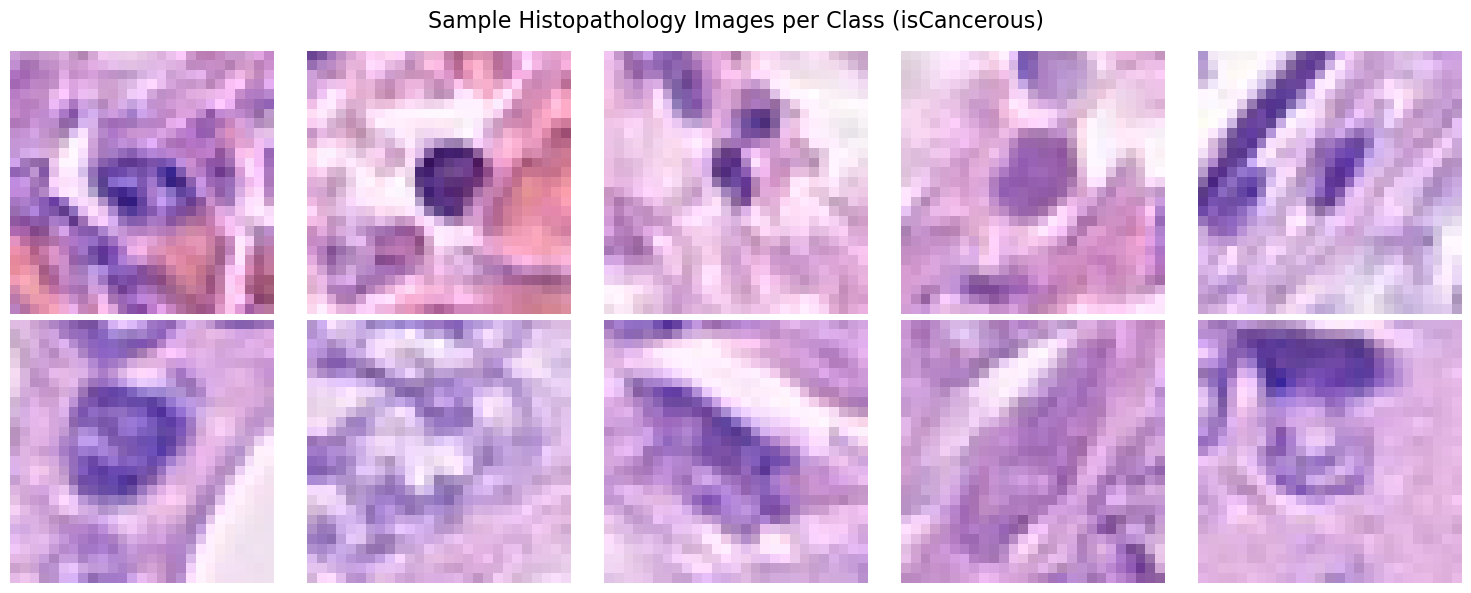

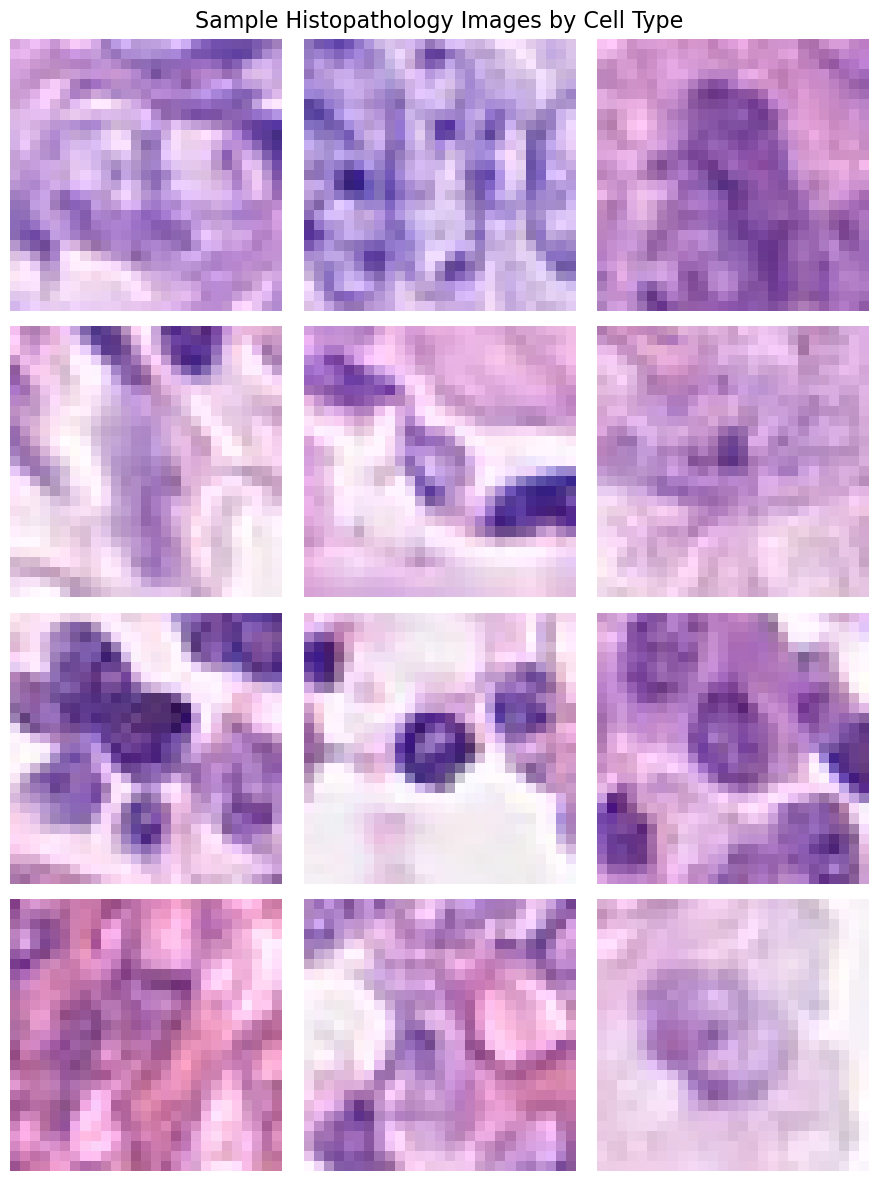

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

# Class Distribution (isCancerous)
print("\nClass distribution in training set:")
print(train_data['isCancerous'].value_counts())
plt.figure(figsize=(6, 4))
sns.countplot(x='isCancerous', data=train_data)
plt.title('Class Distribution (isCancerous) - Training Set')
plt.xlabel('Is Cancerous')
plt.ylabel('Count')
plt.show()

# Cell-Type Distribution
print("\nCell-type distribution in training set:")
print(train_data['cellTypeName'].value_counts())
plt.figure(figsize=(8, 4))
sns.countplot(
    x='cellTypeName',
    data=train_data,
    order=train_data['cellTypeName'].value_counts().index
)
plt.title('Cell Type Distribution - Training Set')
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Patient-Level Patch Counts
plt.figure(figsize=(8, 4))
sns.histplot(train_data['patientID'].value_counts(), bins=20, kde=False)
plt.title('Number of Patches per Patient (Training Set)')
plt.xlabel('Patches per Patient')
plt.ylabel('Count of Patients')
plt.show()


# Sample Images per Class
sample_data = train_data.groupby('isCancerous').sample(n=5, random_state=SEED)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for (cls, grp), ax_row in zip(sample_data.groupby('isCancerous'), axes):
    for img_path, ax in zip(grp['image_path'].values, ax_row):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')
    ax_row[0].set_ylabel(f'Class {cls}', size='large')
plt.suptitle('Sample Histopathology Images per Class (isCancerous)', size=16)
plt.tight_layout()
plt.show()

# Sample Images per Cell Type
sample_by_type = train_data.groupby('cellTypeName').sample(3, random_state=SEED)
fig, axes = plt.subplots(len(sample_by_type['cellTypeName'].unique()), 3, figsize=(9, 12))
for (ctype, grp), row_axes in zip(sample_by_type.groupby('cellTypeName'), axes):
    for img_path, ax in zip(grp['image_path'], row_axes):
        ax.imshow(mpimg.imread(img_path))
        ax.axis('off')
    row_axes[0].set_ylabel(ctype, size='large')
plt.suptitle('Sample Histopathology Images by Cell Type', size=16)
plt.tight_layout()
plt.show()


> <span style="font-size:1em;">✔</span> **Observations**

> **Dataset Overview**
> - The dataset has a total of 9,896 labelled images.
> - After applying a patient-aware split, the dataset was divided into 6,643 training samples, 2,375 validation samples and 878 test samples.  
> - Patient-aware splitting means all patches from one patient are only in one of the sets. This helps avoid data leakage and gives a more realistic test of how well the model generalises to new patients.

> **Class Distribution (`isCancerous`)**
> - As seen in the class distribution plot above, the training set has 4,124 non-cancerous and 2,519 cancerous images.
> - There is some class imbalance (more non-cancerous images), but it’s not extreme.
> - This imbalance could still affect the model, so using class weights during training might help improve results.

> **Validation and Test Class Distribution**
> - Looking at the validation and test set statistics, the validation set has 1,200 non-cancerous and 1,175 cancerous samples.
> - The test set has 493 non-cancerous and 385 cancerous samples.
> - The proportions are similar to the training set, which shows the split kept the class balance consistent.

> **Cell-Type Distribution**
> - From the cell-type bar chart, the most common cell type is epithelial (2,519 samples), followed by inflammatory (1,924), fibroblast (1,192), and others (1,008).
> - Some types have fewer samples, especially “others”.
> - This imbalance might make it harder for the model to learn from those classes. Extra data, augmentation, or class weighting could help.

> **Patient-Level Patch Distribution**
> - As shown in the histogram, some patients contribute over 300 image patches, while others have far fewer.
> - This could make the model focus too much on certain patients’ data and overfit.
> - Splitting by patient (as done here) reduces this risk and helps the model learn more general features.

> **Sample Images per Class (`isCancerous`)**
> - From the image samples above, 10 sample images were shown (5 for each class).
> - Cancerous images usually show darker and more irregular patterns. Non-cancerous ones are lighter and more even.
> - These visual differences show that it should be possible for a model to learn to tell the classes apart.

> **Sample Images per Cell Type**
> - Likewise, 12 sample images were shown (3 for each of the 4 cell types).
> - The cell types look different — for example, epithelial cells appear rounder, while fibroblasts are more stretched.
> - These differences support the idea that a multi-class classification model can work well here.

> **Additional Dataset Acknowledgement**
> - There is another file (`data_labels_extraData.csv`) with over 10,000 more labelled images.
> - This will be used later in the modelling phase to help improve results, especially for the cell-type classification task.

# Data Pre-Processing

**Missing Value Check**
- The dataset was checked for missing values in important columns like image names, labels, and patient IDs.
- This is to make sure there are no empty or broken rows that could cause errors later during training.
- No missing values were found, so no rows needed to be removed.

**Normalisation**
- All image pixel values are scaled from the range [0, 255] to [0, 1] using `rescale=1./255`.
- This is a common and important step in image models because it helps the model learn faster and more smoothly.
- Without this, the large pixel values might slow down training or make it unstable.

**Data Augmentation (Training Set Only)**
- Data augmentation is used to make the training data more varied by randomly changing the images in small ways.
- These changes include rotating, zooming, shifting, shearing and flipping the images.
- It helps the model learn to recognise patterns in different positions and makes it less likely to overfit.
- These changes happen during training, so each epoch the model sees slightly different versions of the same images.

**Validation and Test Rescaling Only**
- The validation and test sets are only rescaled to [0, 1] but are not augmented.
- This keeps them consistent and realistic, so the model is tested on clean data.

**Image Size and Batch Size**
- All images are resized to 27 × 27 pixels to match what the model expects as input.
- A batch size of 32 is used to train efficiently while staying within memory limits.

**Data Generator Setup**
- `flow_from_dataframe()` is used to load the images from the dataset and apply the preprocessing steps on the fly.
- The `class_mode='categorical'` setting automatically turns the cell type labels into one-hot encoded vectors, which is needed for multi-class classification.

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# -------------------------------
# Missing Value Check
# -------------------------------
# Check if any key columns are missing values before proceeding
print("Missing values in dataset:\n", data[['ImageName', 'cellTypeName', 'isCancerous', 'patientID']].isnull().sum())

# -------------------------------
# Normalisation and Augmentation
# -------------------------------
# All pixel values are rescaled to [0, 1]
# Data augmentation is applied only to the training set to improve generalisation

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test sets should not be augmented but only rescaled
val_test_datagen = ImageDataGenerator(rescale=1./255)

# ----------------------
# Image flow parameters
# ----------------------
IMG_SIZE = (27, 27)
BATCH_SIZE = 32

# ----------------------
# Data Generators Setup
# ----------------------

# Flowing training data with augmentation
train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='image_path',
    y_col='cellTypeName',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

# Flowing validation data (no augmentation)
val_generator = val_test_datagen.flow_from_dataframe(
    val_data,
    x_col='image_path',
    y_col='cellTypeName',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Flowing test data (no augmentation)
test_generator = val_test_datagen.flow_from_dataframe(
    test_data,
    x_col='image_path',
    y_col='cellTypeName',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Missing values in dataset:
 ImageName       0
cellTypeName    0
isCancerous     0
patientID       0
dtype: int64
Found 6643 validated image filenames belonging to 4 classes.
Found 2375 validated image filenames belonging to 4 classes.
Found 878 validated image filenames belonging to 4 classes.


# References
https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed </br>
https://matplotlib.org/stable/api/image_api.html </br>
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html </br>
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator